In [8]:
%load_ext autoreload
%autoreload 2

import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from unyt import Jy, nJy

from sbifitter import GeneralEmpiricalUncertaintyModel, SBI_Fitter

device = "cuda:0"

file_path = os.path.dirname(os.path.realpath(os.path.abspath("")))
grid_folder = os.path.join(os.path.dirname(file_path), "grids")
output_folder = os.path.join(os.path.dirname(file_path), "models")

file_path, grid_folder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('/nvme/scratch/work/tharvey/sbifitter/examples',
 '/nvme/scratch/work/tharvey/sbifitter/grids')

In [15]:
grid_path = f"{grid_folder}/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1.hdf5"  # noqa: E501

depth_model_fitter = SBI_Fitter.init_from_hdf5(
    "Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_nonorm_missing",
    grid_path,
    return_output=False,
)

depths = 10 ** ((np.array([29.3] * 20) - 8.90) / -2.5) * Jy  # 30 AB mag in all 22 filters


depth_model_fitter.create_feature_array_from_raw_photometry(
    extra_features=[],
    normalize_method=None,
    depths=depths,
    include_errors_in_feature_array=True,
    scatter_fluxes=3,
)

FileNotFoundError: HDF5 file not found: /nvme/scratch/work/tharvey/sbifitter/grids/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1.hdf5

Here we generate an empirial noise model $p\left(\sigma_X \mid f_X\right)$ 

Black is the true data, and green shows our model

/nvme/scratch/work/tharvey/sbifitter/src/sbifitter/noise_models.py:1395: RuntimeWarning: divide by zero encountered in divide
  mag_err = (2.5 * flux_err) / (flux * np.log(10))


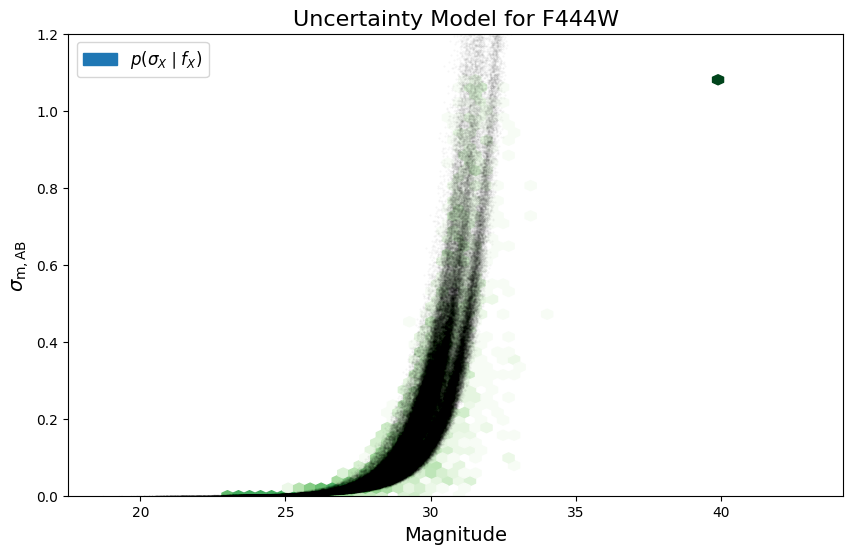

['depth_model.joblib']

In [19]:
from joblib import dump

from sbifitter import create_uncertainity_models_from_EPOCHS_cat

file = "/home/tharvey/Downloads/JADES-Deep-GS_MASTER_Sel-f277W+f356W+f444W_v9_loc_depth_masked_10pc_EAZY_matched_selection_ext_src_UV.fits"  # noqa: E501

file = "/raid/scratch/work/austind/GALFIND_WORK/Catalogues/v13/ACS_WFC+NIRCam/JADES-DR3-GS/(0.32)as/JADES-DR3-GS_MASTER_Sel-F277W+F356W+F444W_v13.fits"

model = create_uncertainity_models_from_EPOCHS_cat(file, "F444W", plot=True, hdu="OBJECTS")


dump(model, "depth_model.joblib")

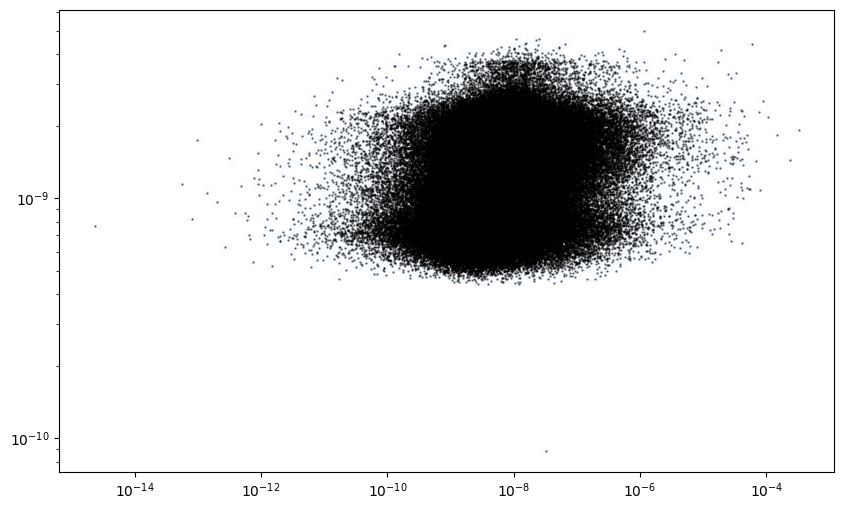

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.

In [10]:
from unyt import Jy

file = "/home/tharvey/Downloads/JADES-Deep-GS_MASTER_Sel-f277W+f356W+f444W_v9_loc_depth_masked_10pc_EAZY_matched_selection_ext_src_UV.fits"  # noqa: E501
file = "/raid/scratch/work/austind/GALFIND_WORK/Catalogues/v13/ACS_WFC+NIRCam/JADES-DR3-GS/(0.32)as/JADES-DR3-GS_MASTER_Sel-F277W+F356W+F444W_v13.fits"
table = Table.read(file, hdu='OBJECTS')

band = "F090W"

flux = table[f"FLUX_APER_{band}_aper_corr_Jy"]#[:, 0]
flux_err = table[f"FLUXERR_APER_{band}_loc_depth_10pc_Jy"]#[:, 0]

flux_err = table[f"loc_depth_{band}"] * u.ABmag #[:, 0]
flux_err = flux_err.to("Jy").value / 5

# drop NaNs and -99's

mask = (flux > 0) & (flux_err > 0)
flux = flux[mask]
flux_err = flux_err[mask]
# bin and plot as contour
plt.figure(figsize=(10, 6))

plt.hexbin(
    flux,
    flux_err,
    cmap="Blues",
    mincnt=1,
    bins=100,
    xscale="log",
    yscale="log",
)
plt.scatter(flux, flux_err, alpha=0.5, color="black", s=0.5, zorder=10)
# plt.xscale('log')
# plt.yscale('log')
plt.show()


noise_model = GeneralEmpiricalUncertaintyModel(
    flux,
    flux_err,
    num_bins=100,
    log_bins=True,
    error_type="observed",
    flux_unit=Jy,
)
noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(
    flux, true_flux_units=Jy, out_units="AB"
)


# plt.scatter(noisy_flux, sampled_sigma, alpha=0.1, color='green', s=0.1)
plt.hexbin(
    noisy_flux,
    sampled_sigma,
    gridsize=50,
    cmap="Greens",
    mincnt=1,
    alpha=1,
    label=r"$p\left(\sigma_X \mid f_X\right)$",
    xscale="log",
    yscale="linear",
)
fmag = table[f"MAG_APER_{band}_aper_corr"][:, 0]
ferr = table[f"MAGERR_APER_{band}_u1_loc_depth"][:, 0]

mask = (fmag != -99) & (ferr != -99) & (fmag > 0) & (ferr > 0)
fmag = fmag[mask]
ferr = ferr[mask]


plt.scatter(fmag, ferr, alpha=0.03, color="black", s=0.1, zorder=10)

plt.legend()

### asinh magnitudes



In [ ]:
grid_path = f"{grid_folder}/grid_Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1.hdf5"  # noqa: E501

asinh_depth_model_fitter = SBI_Fitter.init_from_hdf5(
    "Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_nonorm_missing",
    grid_path,
    return_output=False,
)

depths = 10 ** ((np.array([29.3] * 20) - 8.90) / -2.5) * Jy  # 30 AB mag in all 22 filters

asinh_depth_model_fitter.create_feature_array_from_raw_photometry(
    extra_features=[],
    normalize_method=None,
    depths=depths,
    include_errors_in_feature_array=True,
    scatter_fluxes=3,
    normed_flux_units="asinh",
    asinh_softening_parameters="SNR_5",
)

In [ ]:
from sbifitter import f_jy_err_to_asinh, f_jy_to_asinh

mag = np.arange(26, 38, 0.1)
f_jy = 10 ** ((mag - 8.90) / -2.5) * Jy  # convert AB mag to Jy

asinh = f_jy_to_asinh(f_jy, f_b=5 * nJy)
err = np.ones(len(f_jy)) * nJy

plt.scatter(mag, asinh, s=0.1, color="red", label="asinh depth model")
plt.xlabel("AB Mag")
plt.ylabel("Asinh Mag")
# label 5 nJy
plt.axhline(
    y=f_jy_to_asinh(5 * nJy, f_b=5 * nJy), color="red", linestyle="--", label="5 nJy"
)
plt.show()
asinh_err = f_jy_err_to_asinh(
    f_jy,
    err,
    f_b=5 * nJy,
)

plt.scatter(f_jy / err, asinh_err, s=0.1, color="red", label="asinh depth model error")

In [ ]:
flux = -10 * nJy  # example flux in Jy
error = 40 * nJy  # example error in Jy
f_b = 5 * nJy  # softening parameter in Jy

f_jy_to_asinh(flux, f_b), f_jy_err_to_asinh(flux, error, f_b)

In [12]:
jades_filters = [
    "F090W",
    "F115W",
    "F150W",
    "F200W",
    "F277W",
    "F335M",
    "F356W",
    "F410M",
    "F444W",
]

empirical_noise_models = {}
data = []
for filter_name in jades_filters:
    fitter_filter_name = f"NIRCam.{filter_name.upper()}"

    flux = table[f"MAG_APER_{filter_name}_aper_corr"]#[:, 0]
    data.append(flux)

    flux_err_l = table[f"MAGERR_APER_{filter_name}_l1_loc_depth"]#[:, 0]
    flux_err_u = table[f"MAGERR_APER_{filter_name}_u1_loc_depth"]#[:, 0]

    mask = (
        (flux != -99)
        & (flux_err_l != -99)
        & (flux_err_u != -99)
        & (flux_err_l > 0)
        & (flux_err_u > 0)
    )
    flux = flux[mask]
    flux_err_l = flux_err_l[mask]
    flux_err_u = flux_err_u[mask]

    noise_model = GeneralEmpiricalUncertaintyModel(
        flux,
        (flux_err_l + flux_err_u) / 2,
        num_bins=20,
        log_bins=True,
        min_flux_error=0.01,
        sigma_clip=10,
        upper_limits=True,
        treat_as_upper_limits_below=0.5,
        error_type="observed",
    )
    empirical_noise_models[fitter_filter_name] = noise_model


# Plot median line for all
flux_test = np.linspace(23, 31, 1000)
colors = plt.cm.viridis(np.linspace(0, 1, len(empirical_noise_models)))
for a, (filter_name, noise_model) in enumerate(empirical_noise_models.items()):
    noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(
        flux_test, true_flux_units="AB"
    )
    plt.scatter(
        noisy_flux,
        sampled_sigma,
        label=f"{filter_name}",
        alpha=0.5,
        color=colors[a],
        s=1,
    )
plt.xlabel("Flux (AB mag)")
plt.ylabel("Sampled Flux Error (AB mag)")

plt.legend()

empirical_noise_models["NIRCam.F444W"].get_valid_flux_range()

KeyError: 'MAGERR_APER_F090W_l1_loc_depth'

In [ ]:
np.sum(
    np.isnan(sampled_sigma)
    | np.isinf(sampled_sigma)
    | np.isnan(noisy_flux)
    | np.isinf(noisy_flux)
)

In [ ]:
jades_filters = [
    "f090W",
    "f115W",
    "f150W",
    "f200W",
    "f277W",
    "f335M",
    "f356W",
    "f410M",
    "f444W",
]

empirical_noise_models = {}

for filter_name in jades_filters:
    fitter_filter_name = f"NIRCam.{filter_name.upper()}"

    flux = table[f"FLUX_APER_{filter_name}_aper_corr_Jy"][:, 0]
    flux_err = table[f"loc_depth_{band}"][:, 0] * u.ABmag
    flux_err = flux_err.to("Jy").value / 5

    mask = (flux != -99) & (flux_err != -99) & (flux_err > 0)
    flux = flux[mask]
    flux_err = flux_err[mask]

    noise_model = GeneralEmpiricalUncertaintyModel(
        flux,
        flux_err,
        num_bins=100,
        log_bins=True,
        min_flux_error=0,
        sigma_clip=10,
        error_type="observed",
        upper_limits=True,
        treat_as_upper_limits_below=0.5,
        flux_unit=Jy,
    )
    empirical_noise_models[fitter_filter_name] = noise_model


# Plot median line for all
flux = np.linspace(23, 100, 1000)
colors = plt.cm.viridis(np.linspace(0, 1, len(empirical_noise_models)))
for a, (filter_name, noise_model) in enumerate(empirical_noise_models.items()):
    noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(
        flux, true_flux_units="AB", out_units="AB"
    )
    plt.scatter(
        noisy_flux,
        sampled_sigma,
        label=f"{filter_name}",
        alpha=0.5,
        color=colors[a],
        s=1,
    )
plt.xlabel("Flux (AB mag)")
plt.ylabel("Sampled Flux Error (AB mag)")

plt.legend()

empirical_noise_models["NIRCam.F444W"].get_valid_flux_range()

In [ ]:
np.sum(
    np.isnan(sampled_sigma)
    | np.isinf(sampled_sigma)
    | np.isnan(noisy_flux)
    | np.isinf(noisy_flux)
)

In [ ]:
empirical_model_fitter = SBI_Fitter.init_from_hdf5(
    "Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_empirical_noise_NOLIM",
    grid_path,
    return_output=False,
)

empirical_model_fitter.create_feature_array_from_raw_photometry(
    extra_features=[],
    normalize_method=None,
    include_errors_in_feature_array=True,
    scatter_fluxes=4,
    empirical_noise_models=empirical_noise_models,
    norm_mag_limit=5000,
    photometry_to_remove=[
        filt
        for filt in empirical_model_fitter.raw_photometry_names
        if filt not in list(empirical_noise_models.keys())
    ],
);

In [ ]:
from sbifitter import filter_out_of_distribution

data = np.array(data)
observed_photometry = np.array(data).T

# drop any row with a -99

mask = np.all(observed_photometry != 99, axis=1)
observed_photometry = observed_photometry[mask]


# DO this with real data
simulated_photometry = empirical_model_fitter.feature_array[:, :9]

filtered_photometry, removed_indices = filter_out_of_distribution(
    observed_photometry=observed_photometry.T,
    simulated_photometry=simulated_photometry.T,
    sigma_threshold=5,
)

# compare distribution of fluxes before and after filtering

fig, axs = plt.subplots(
    3, np.ceil(len(observed_photometry[0]) / 3).astype(int), figsize=(15, 10)
)
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(observed_photometry[0]):
        ax.hist(observed_photometry[:, i], bins=50, alpha=0.5, label="Observed")
        ax.hist(simulated_photometry[:, i], bins=50, alpha=0.5, label="Simulated")
        ax.hist(
            filtered_photometry[i],
            bins=50,
            alpha=0.5,
            label="Filtered Simulated",
        )
        ax.set_title(f"{jades_filters[i]} Flux Distribution")
        ax.legend()
    else:
        ax.axis("off")

In [ ]:
plt.hist(
    empirical_model_fitter.feature_array[:, 8],
    bins=100,
    alpha=0.5,
    label="Model Flux",
    color="red",
);

In [ ]:
empirical_model_fitter.run_single_sbi(
    n_nets=1,
    backend="lampe",
    engine="NPE",
    name_append="v2_empirical_noise_uplim",
    stop_after_epochs=15,
    hidden_features=180,
    learning_rate=0.0004,
    num_transforms=16,
    model_type="nsf",
)

In [ ]:
selected_cat = table[table["final_sample_highz_fsps_larson_no_bd"]]

selected_cat["NUMBER", "MAG_APER_f444W_aper_corr", "zbest_fsps_larson"]

id = 816
plot = True
all_samples = []
X_tests = []
for id in selected_cat["NUMBER"]:
    row = selected_cat[selected_cat["NUMBER"] == id]

    flux = []
    err = []

    for filter_name in jades_filters:
        f = row[f"MAG_APER_{filter_name}_aper_corr"][0][0]
        if f == 99:
            f = 50

        flux.append(f)
        errsL = row[f"MAGERR_APER_{filter_name}_l1_loc_depth"][0][0]
        errsU = row[f"MAGERR_APER_{filter_name}_u1_loc_depth"][0][0]
        # print(errsL, errsU)
        if errsL == -99 and errsU != -99:
            if errsU < 0.01:
                err.append(0.01)
            err.append(errsU)
        elif errsU == -99 and errsL == -99:
            err.append(1.6)
        else:
            e = (
                row[f"MAGERR_APER_{filter_name}_l1_loc_depth"][0][0]
                + row[f"MAGERR_APER_{filter_name}_u1_loc_depth"][0][0]
            ) / 2
            if e < 0.01:
                e = 0.01

            err.append(e)

    flux = np.array(flux)
    err = np.array(err)

    x_test = np.concatenate((flux, err))
    X_tests.append(x_test)

all_samples = empirical_model_fitter.sample_posterior(X_test=X_tests)


# plot posterior sample histogram
if plot:
    for j, id in enumerate(selected_cat["NUMBER"][:10]):
        fig, axs = plt.subplots(
            2,
            int(len(empirical_model_fitter.fitted_parameter_names) / 2),
            figsize=(20, 6),
            sharey=True,
        )
        axs = axs.flatten()
        for i, name in enumerate(empirical_model_fitter.simple_fitted_parameter_names):
            axs[i].hist(
                all_samples[j, :, i],
                bins=50,
                density=True,
                alpha=0.5,
                label="Posterior Samples",
            )
            axs[i].set_title(name)
            axs[i].set_xlabel(name)
            axs[i].set_ylabel("Density")
            axs[i].legend()

        true_redshift = row["zbest_fsps_larson"][0]
        axs[0].axvline(true_redshift, color="red", linestyle="--", label="True Redshift")
        fig.suptitle(f"Posterior Samples for ID {id}", fontsize=16)
        plt.tight_layout()
        plt.show()

all_samples = np.array(all_samples)

all_redshifts = all_samples[:, :, 0]

print(all_redshifts.shape)

In [ ]:
upper, median, lower = np.percentile(all_redshifts, [84, 50, 16], axis=1)

all_table_redshifts = np.squeeze(selected_cat["zbest_fsps_larson"].data)
all_table_upper = np.squeeze(selected_cat["zbest_16_fsps_larson"].data)
all_table_lower = np.squeeze(selected_cat["zbest_84_fsps_larson"].data)
mask = selected_cat["zbest_fsps_larson"].data < 12
all_table_redshifts = all_table_redshifts[mask]
all_table_upper = all_table_upper[mask]
all_table_lower = all_table_lower[mask]
upper = upper[mask]
median = median[mask]
lower = lower[mask]

plt.figure(figsize=(10, 6))

xerr = np.abs(
    np.array(
        [
            all_table_redshifts - all_table_lower,
            all_table_upper - all_table_redshifts,
        ]
    )
)
yerr = np.abs(np.array([lower - median, upper - median]))


plt.errorbar(
    all_table_redshifts,
    median,
    xerr=xerr,
    yerr=yerr,
    fmt="o",
    label="Empirical Model",
    color="blue",
    alpha=0.5,
)

# add a 1:1
plt.plot([5, 12], [5, 12], color="black", linestyle="--", label="1:1 Line")

plt.xlabel("EAZY Redshift")
plt.ylabel("SBI Model Redshift")

First model

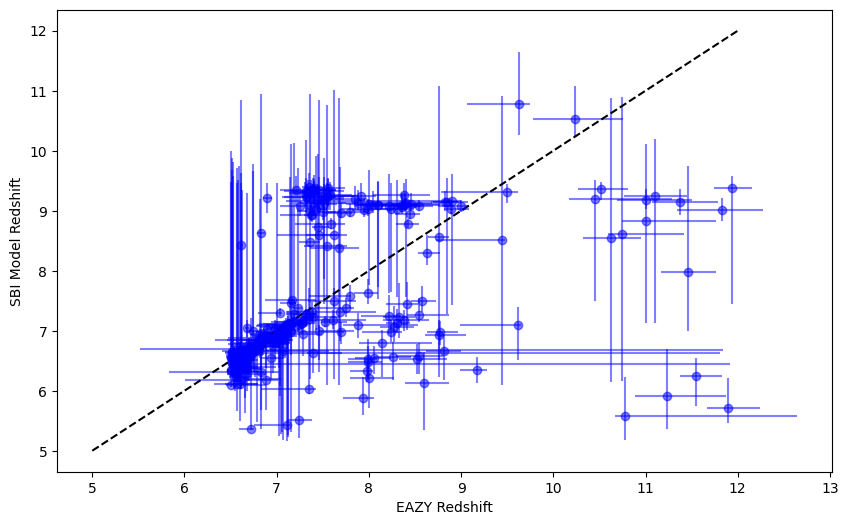

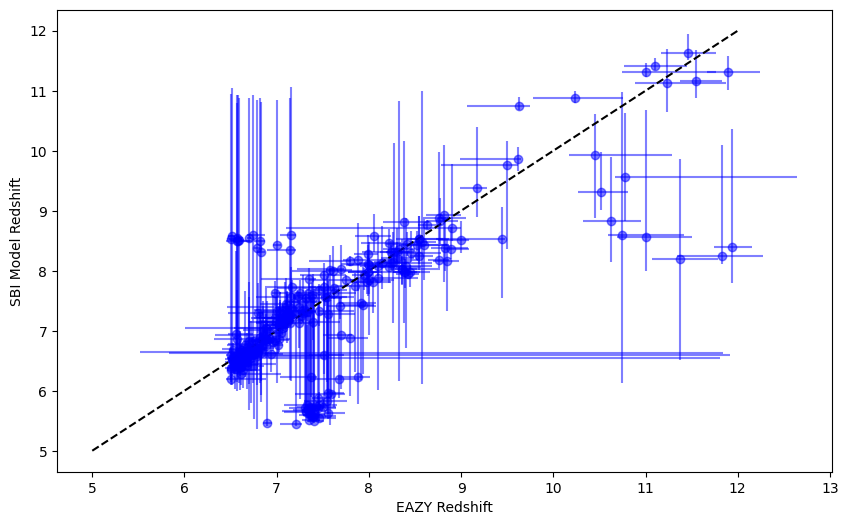

In [ ]:
plt.hist(noisy_flux, bins=100, alpha=0.5, label="Noisy Flux")
plt.hist(flux, bins=100, alpha=0.5, label="True Flux", color="orange")
plt.hist(
    selected_cat["MAG_APER_f090W_aper_corr"][:, 0],
    bins=100,
    alpha=0.5,
    label="Catalog Flux",
    color="green",
    range=(23, 40),
)
plt.hist(
    empirical_model_fitter.feature_array[:, 0],
    bins=100,
    alpha=0.5,
    label="Model Flux",
    color="red",
    range=(23, 40),
);

In [ ]:
mask = selected_cat["zbest_fsps_larson"].data > 8

high_plot = X_tests[mask]

samples = empirical_model_fitter.feature_array[
    empirical_model_fitter.fitted_parameter_array[:, 0] > 8
]

plt.hist(
    samples[:, 0],
    bins=10,
    density=True,
    alpha=0.5,
    label="SBI Model F090W Dist (z>8)",
    color="orange",
)
plt.hist(
    high_plot[:, 0],
    bins=10,
    density=True,
    alpha=0.5,
    label="EAZY F090W Dist (z>8)",
    color="green",
)

In [ ]:
# count rows in feature array where all fluxes are less than 30
X_tests = np.array(X_tests)
# More than half the bands are greater than mag 32.
print(
    np.sum(
        np.sum(empirical_model_fitter.feature_array[:, :8] > 32, axis=1) > 10,
        axis=0,
    )
    / len(depth_model_fitter.feature_array)
    * 100
)

# do the same for the real data

print(np.sum(np.sum(X_tests[:, :8] > 32, axis=1) > 10, axis=0) / len(X_tests) * 100)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for pos, (name, noise_model) in enumerate(empirical_noise_models.items()):
    noise_model.plot_sigma(ax=ax, label=name, alpha=0.5)

ax.legend()

In [ ]:
a = empirical_model_fitter.fitted_parameter_array[:, 0]

b = empirical_model_fitter.feature_array[:, 8]

plt.figure(figsize=(10, 6))

plt.hexbin(a, b, gridsize=50, cmap="Blues", extent=(5, 12, 20, 51))

In [ ]:
b = empirical_model_fitter.feature_array[:, 8]
c = empirical_model_fitter.feature_array[:, -1]

plt.figure(figsize=(10, 6))
plt.hexbin(b, c, gridsize=50, cmap="Blues", extent=(20, 40, 0, 1), mincnt=1)

plt.show()

plt.hist(b, bins=50, density=False, alpha=0.5, label="Feature 8")

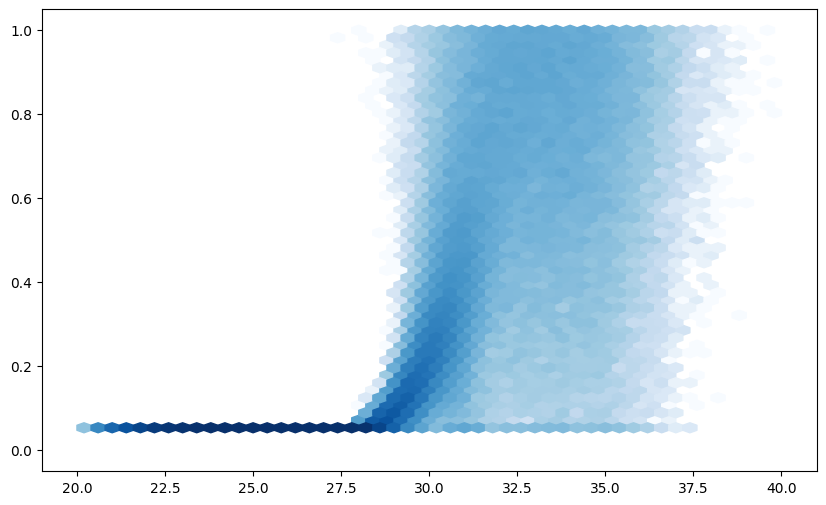

In [ ]:
# Count how many rows of feature_array have all features > 34

count_above_34 = np.sum(np.all(empirical_model_fitter.feature_array > 34, axis=1))

### Model testing

In [ ]:
from synthesizer.emission_models.dust.emission import IR_templates
from synthesizer.grid import Grid

path = os.path.environ("SYNTHESIZER_GRID_DIR")

dl07_grid = Grid("draine_li_dust_emission_grid_MW_3p1", grid_dir=path, read_lines=False)

In [ ]:
from unyt import Angstrom, Msun

lam = 10 ** (np.arange(3.0, 8.0, 0.01))
lam = lam * Angstrom  # Convert to Angstroms

for mdust in [1e7, 1e8, 5e8, 1e9, 5e9]:
    model = IR_templates(dl07_grid, mdust=mdust * Msun, verbose=False)
    sed = model.get_spectra(lam)

    # Normalise the SED to the bolometric luminosity
    sed._lnu /= sed._bolometric_luminosity

    # And plot...
    plt.loglog(
        sed.lam,
        sed.luminosity,
        label="{:.1e} Msun, <U>={:.2f}".format(mdust, model.u_avg),
    )
    plt.title("Draine & Li 2007")

plt.xlabel(r"$ \lambda / \AA$")
plt.ylabel(r"$ L_{\nu} / L_{bol}$")
plt.ylim(10**-3, 1)
plt.legend()
plt.show()

/tmp/ipykernel_218933/3542921400.py:10: RuntimeWarning: invalid value encountered in log10
  mag_err_down = -2.5 * np.log10(1 - flux_err / flux)  # Convert flux error to AB mag error


Text(0, 0.5, 'AB Magnitude Error')

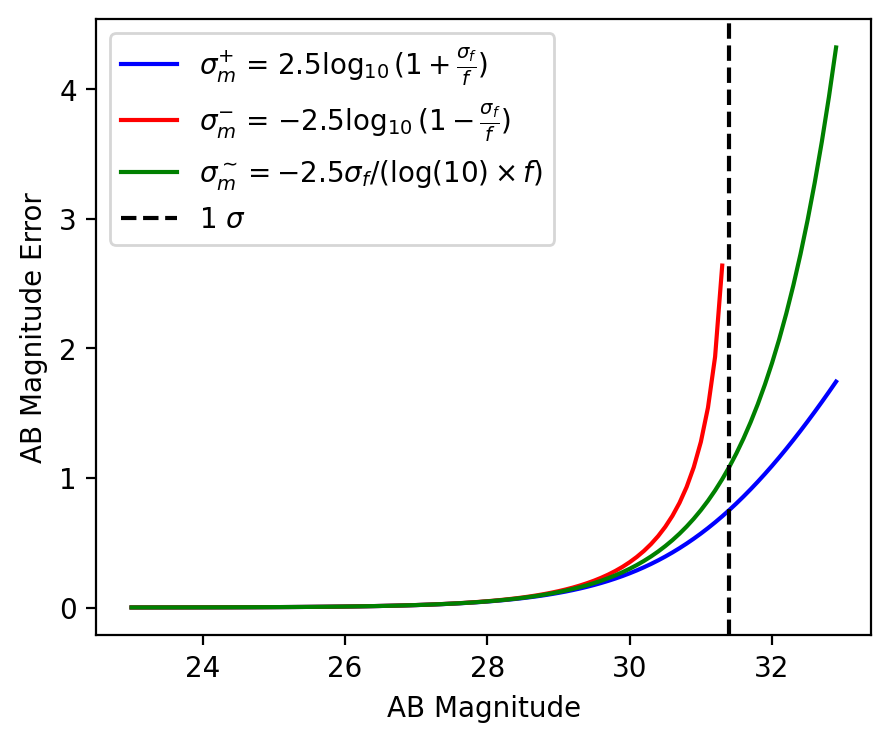

In [13]:
import matplotlib.pyplot as plt
import numpy as np

mag = np.arange(23, 33, 0.1)

flux = 10 ** (-0.4 * (mag - 8.9))  # Convert AB mag to flux in Jy
flux_err = 1e-9

mag_err_up = 2.5 * np.log10(1 + flux_err / flux)  # Convert flux error to AB mag error
mag_err_down = -2.5 * np.log10(1 - flux_err / flux)  # Convert flux error to AB mag error

mag_err_aprox = (
    np.abs(-2.5 / (np.log(10) * flux)) * flux_err
)  # Approximate error in AB mag
plt.figure(figsize=(5, 4), dpi=200)
plt.plot(
    mag,
    mag_err_up,
    label=r"$ \sigma_{m}^{+}$ = $2.5 \log_{10}(1 + \frac{\sigma_{f}}{f})$",
    color="blue",
)
plt.plot(
    mag,
    mag_err_down,
    label=r"$ \sigma_{m}^{-}$ = $-2.5 \log_{10}(1 - \frac{\sigma_{f}}{f})$",
    color="red",
)
plt.plot(
    mag,
    mag_err_aprox,
    label=r"$ \sigma_{m}^{\sim}  = -2.5\sigma_{f}/(\log(10) \times f) $",
    color="green",
)

# label1 sigma

mag_1sig = -2.5 * np.log10(flux_err) + 8.90

plt.axvline(mag_1sig, color="black", linestyle="--", label=r"1 $\sigma$")
plt.legend()
plt.xlabel("AB Magnitude")
plt.ylabel("AB Magnitude Error")